In [1]:
%load_ext autoreload

In [10]:
%autoreload 2
import logging
import seaborn as sns
import numpy as np
import cmdstanpy

from baynes.plotter import FitPlotter
from baynes.toyMC import SpectraSampler
from baynes.analysis import standard_analysis, multithreaded_run
from baynes.probability import HoSpectrum, hdi, ptolemy
from baynes.model_utils import get_model
from numba import njit, prange

from sympy import symbols, sin, diff, erf, exp, sqrt, Piecewise, And
from sympy.utilities.lambdify import lambdify
from scipy.special import gamma
from scipy.constants import elementary_charge, hbar, c, electron_mass

from math import erf, exp, sqrt
import matplotlib.pyplot as plt

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
coeffs = np.loadtxt("parameters.dat")[:,1:]

from scipy.constants import hbar, c



# TODO
- Preliminare:
    * normalizzazione
    * media di bin vicini
- Sensitivity analitica
- Base:
    * Prior $m_\nu$
    * andamento statistica m=0
    * andamento m=0.3
- Sistematiche:
    * Qs 0.1 per statistica bassa e alta
    * Qs 0.01 per statistica alta
    * FWHM per alta?

Confronto con beta?

(-10.0, 10.0)

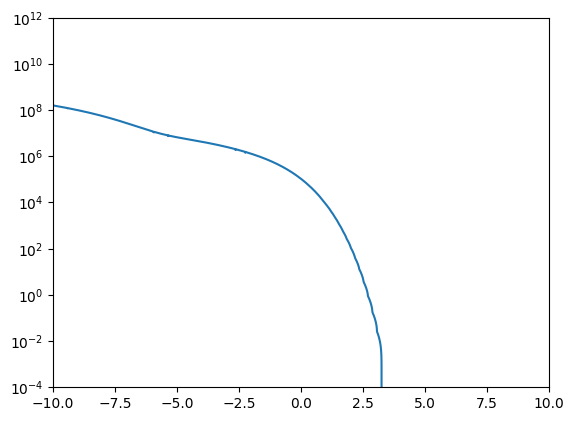

In [3]:
me = 510998.95
mT = 931.49410242e6*3.01604928;
mhe3 = 931.49410242e6*3.0160293;
mhe = mhe3 - me + 24.6
Q = mT - mhe - me;
Krec = 3.44;
K0 = Q-Krec
g_to_ev = 5.6095883571872E+32
dE = 0.001
E = np.arange(Q-20, Q+5, dE)
m_nu=0.2
y = 1e-3*365*24*3600*ptolemy(E, coeffs, m_nu, Q)
plt.plot(E-K0, y)
plt.yscale("log")
plt.ylim(1e-4, 1e12)
plt.xlim(-10, 10)

In [11]:
@njit(parallel=True)
def ptolemyint(E, coeffs, m_nu, Q=18589.8):
    """Compute the b-decay spectrum of tritium in graphene."""
    y = 0
    me = 510998.95
    mhe3 = 931.49410242e6*3.0160293
    lambda_val = 4.21e-5
    eps0 = 5.76
    Gf = 1.1663787e-23
    Vud = 0.97373
    gsq = (Gf*Vud)**2 * (1+(1.25*1.65)**2)
    NH3=1/1.66054e-24/3.01604928

    const_discrspe=NH3*gsq*lambda_val**2/(4 * np.pi**3 * 6.582119e-16)
    const_contspe=NH3*gsq*lambda_val/(2 * np.pi**(7./2.) * 6.582119e-16)


    i_disc = lambda_val / (2 * np.pi**3)
    pb = np.sqrt(E**2 + 2 * E * me)

    for k in prange(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        if E_nu >= m_nu:
            xb = (pb - pn) / pn
            y += (
                const_discrspe
                * pb
                * (E + me)
                * np.sqrt(E_nu**2 - m_nu**2)
                * E_nu
                * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn))
            )

    i_cont = 1 / (np.pi ** (7. / 2.))
    QKE = Q - E - eps0
    if QKE >= m_nu:
        b = -pb + np.sqrt(2 * mhe3 * (QKE - m_nu))
        bl = b * lambda_val
        pl = pb * lambda_val
        expbl = np.exp(-(bl**2))
        exppl = np.exp(-(pl**2))
        erfplbl = erf(pl) + erf(bl)
        pb2_2mhe3 = pb ** 2 / (2 * mhe3)
        kinf2 = np.sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3)) ** 2)
        I0 = (
            np.sqrt(np.pi)
            / (2 * lambda_val)
            * pb
            * (QKE - pb2_2mhe3) ** 2
            * erfplbl
        )
        I1 = (
            1
            / (2 * lambda_val**2)
            * (QKE - pb2_2mhe3)
            * (QKE - 5.0 * pb2_2mhe3)
            * (exppl - expbl)
        )
        I2 = (
            1
            / (4 * lambda_val**3)
            * ((5.0 * pb2_2mhe3 - 3.0 * QKE) * pb / mhe3)
            * (-2 * pl * exppl - 2 * bl * expbl + np.sqrt(np.pi) * erfplbl)
        )
        I3 = (
            1
            / (2 * lambda_val**4)
            * ((5.0 * pb2_2mhe3 - QKE) / mhe3)
            * (exppl * (1 + pl**2) - expbl * (1 + bl**2))
        )
        I4 = (
            5
            * pb
            / (32 * mhe3**2 * lambda_val**5)
            * (
                -expbl * (6 * bl + 4 * bl**3)
                - exppl * (6.0 * pl + 4 * pl**3)
                + 3 * np.sqrt(np.pi) * erfplbl
            )
        )
        I5 = (
            1
            / (8 * mhe3**2 * lambda_val**6)
            * (
                exppl * (2 + 2 * pl**2 + pl**4)
                - expbl * (2.0 + 2.0 * bl**2 + bl**4)
            )
        )
        y += const_contspe * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5)

    #norm = lambda_val * gsq / (2*mhe3)

    return y

In [13]:
from scipy import integrate
integrate.quad(ptolemyint, Q-10, Q, args = tuple([coeffs, m_nu, Q]))

/tmp/ipykernel_6057/2447121553.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(ptolemyint, Q-10, Q, args = tuple([coeffs, m_nu, Q]))


(916.164987663027, 0.0003005129572102305)

In [6]:
ptolemy(1, coeffs, m_nu, Q)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(int64, 0d, C), int64)
 
There are 22 candidate implementations:
      - Of which 20 did not match due to:
      Overload of function 'getitem': File: <numerous>: Line N/A.
        With argument(s): '(array(int64, 0d, C), int64)':
       No match.
      - Of which 2 did not match due to:
      Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 209.
        With argument(s): '(array(int64, 0d, C), int64)':
       Rejected as the implementation raised a specific error:
         NumbaTypeError: cannot index array(int64, 0d, C) with 1 indices: [int64]
  raised from /home/pietro/work/TESI/BAYNES/baynesenv/lib/python3.10/site-packages/numba/core/typing/arraydecl.py:131

During: typing of intrinsic-call at /home/pietro/work/TESI/BAYNES/baynes/baynes/probability.py (137)

File "../baynes/probability.py", line 137:
def ptolemy(E, coeffs, m_nu, Q=18589.8):
    <source elided>
        for j in range(N):
            E_nu = Qn - E[j]
            ^


In [242]:
len(1)

TypeError: object of type 'int' has no len()

In [216]:
print(sum(y)*dE)

3521942035.4075804


In [155]:
from math import factorial, exp, log, sqrt, pi

@njit
def poisson(N, mean):
    if mean == 0:
        return 0
    elif N > 100:
        return exp(-(N-mean)**2/(2*N))/ sqrt(- 2* pi*sqrt(N))
    elif N == 0:
        return N*log(mean) - mean - 1
    else:
        return N*log(mean) - mean - 1 - N*(N-1)/2


@njit
def likelihood(N, bin_edges, data, coeffs, m, Q):
    y_edges = ptolemy(bin_edges, coeffs, m, Q)
    y_centers = (y_edges[1:]+y_edges[0:-1])/2
    y_centers = y_centers* sum(data)/sum(y_centers)
    likelihood = 0
   # for i in prange(N):
    #    likelihood+=poisson(data[i], y_centers[i])
    return y_centers

def loggaus(x, mu, sigma):
    return -(x-mu)**2/(2*sigma**2) - pi*sigma

AttributeError: module 'numpy' has no attribute 'factorial'

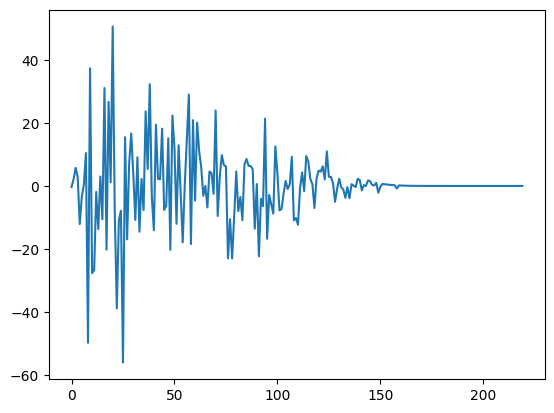

In [156]:
plt.plot(likelihood(len(events), s.ROI_bin_edges, events, coeffs, 0, Q)-events)

In [139]:
from numba import prange

In [144]:
Qs= np.linspace(Q-2, Q+5, 50)
ms=np.linspace(0, 1, 10)

ls = [[likelihood(len(events), s.ROI_bin_edges, events, coeffs, mnu, Qval)+loggaus(Qval, Q, 0.1) for Qval in Qs] for mnu in ms]

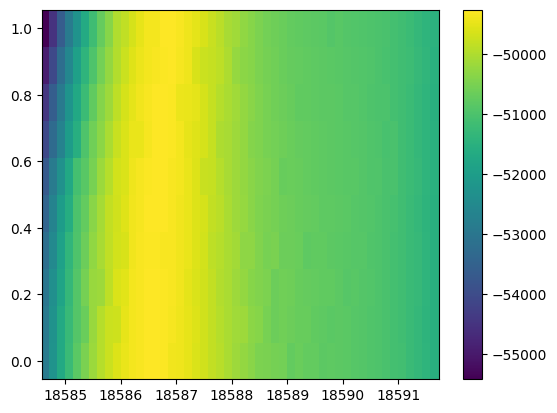

In [145]:
plt.pcolor(Qs, ms, ls)
plt.colorbar()

In [142]:
ls

[[-52693.77690309125,
  -52165.45163210593,
  -51492.03638766887,
  -50963.57640117665,
  -50666.11431509421,
  -50300.00855033801,
  -50200.78372408101,
  -50006.913694078125,
  -49773.0584936024,
  -49605.759421734074,
  -49486.23540772728,
  -49373.128370436,
  -49308.22585911168,
  -49293.59988691393,
  -49305.950933446176,
  -49292.614593242586,
  -49336.8186157326,
  -49396.68650797742,
  -49474.26737417109,
  -49576.251657824374,
  -49695.172153273925,
  -49769.53584938865,
  -49868.60215492137,
  -49983.95931651934,
  -50053.63999352044,
  -50158.69789261778,
  -50201.36834587549,
  -50239.27116033972,
  -50283.16986044082,
  -50339.5091484215,
  -50329.563737950535,
  -50354.262351674486,
  -50351.18409509527,
  -50346.80520809797,
  -50337.19987197168,
  -50323.62056564394,
  -50302.36217947036,
  -50283.70364988209,
  -50258.61445794287,
  -50246.71839394354,
  -50223.194121095614,
  -50197.56891844742,
  -50194.34633348118,
  -50182.082218574804,
  -50173.1493470726,
  -501

In [146]:
logs = np.array(ls)

In [151]:
np.exp(logs-np.sum(logs))

/tmp/ipykernel_14416/1777463741.py:1: RuntimeWarning: overflow encountered in exp
  np.exp(logs-np.sum(logs))


array([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf],
       [inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
        inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf, inf,
     

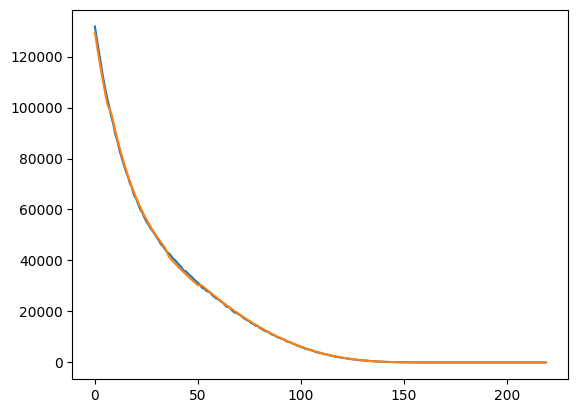

In [67]:
plt.plot(events)
plt.plot(y)

In [24]:
events

array([132179, 127263, 121709, 116953, 112615, 108866, 104400, 100409,
        96763,  93119,  89027,  86745,  82856,  80807,  77284,  75312,
        72802,  69990,  67791,  66062,  63951,  62235,  60334,  58537,
        57394,  55531,  53937,  52856,  51408,  50164,  49248,  47495,
        46519,  45260,  44678,  43912,  42610,  42016,  41165,  39870,
        39056,  38285,  37713,  36342,  35845,  34550,  34463,  33125,
        33107,  31850,  31201,  30557,  29970,  29096,  28451,  27805,
        27100,  26540,  25603,  25370,  24088,  23982,  23061,  22745,
        22277,  21266,  21031,  20389,  19765,  19320,  18887,  18138,
        17418,  17167,  16597,  16362,  15550,  15035,  14623,  14075,
        13743,  13129,  12782,  12263,  11961,  11395,  11055,  10719,
        10159,   9917,   9599,   9123,   8767,   8478,   8098,   7794,
         7365,   7177,   6893,   6450,   6098,   5785,   5506,   5285,
         5087,   4843,   4557,   4223,   4116,   3776,   3616,   3315,
      

In [25]:
np.sum(3.14e7*1000*ptolemy(E, coeffs, m_nu, Q)*1e-9)*dE

373237224543.1398

In [52]:
1/(1.78266192e-36)

5.609588608927036e+35

In [26]:
mT-mhe3

18611.252170085907

In [ ]:
def allowed_beta(E, m_nu, Q=18589.6, Z=1):
    me = 510998.95
    p = np.sqrt(E**2+E*me)
    alpha = 1/137
    eta = Z* alpha * E/p
    F = 2*np.pi/(1-np.exp(-2*np.pi*eta))
    return F*p*(E+me)*(Q-E)*np.sqrt(np.clip((Q - E) ** 2 - m_nu**2, 0, None)) + 1e-8


def allowed_betasy():
    E = symbols("E")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    p = sqrt(E**2+E*me)
    alpha = 1/137
    eta = alpha * E/p
    F = 2*np.pi/(1-exp(-2*np.pi*eta))
    return Piecewise((F*p*(E+me)*(Q-E)*sqrt((Q - E) ** 2 - m_nu**2), And(Q-E>=m_nu, m_nu>=0, Q>=0)),(0, True))+1e-8


m_nu = symbols("m_nu")
E = symbols("E")
Q = symbols("Q")
partial_m_beta = diff(allowed_betasy(), m_nu)
dens_beta = 1/allowed_betasy() * (partial_m_beta**2)
f_beta = lambdify((E, m_nu, Q), dens_beta, "numpy")

In [ ]:
def ptolemysym(coeffs):
    """Compute the b-decay spectrum of tritium in graphene."""
    E = symbols("E")
    y = symbols("y")
    m_nu, Q = symbols("m_nu, Q")
    me = 510998.95
    mhe3 = 2809413505.67592
    lambda_val = 4.21e-5
    eps0 = 5.76

    i_disc = lambda_val / (2 * np.pi**3)
    pb = sqrt(E**2 + 2 * E * me)

    y = 0
    for k in range(64):
        Qn = Q - coeffs[k][0]
        pn = coeffs[k][1]
        an = coeffs[k][2]
        bn = coeffs[k][3]
        cn = coeffs[k][4]
        E_nu = Qn - E
        xb = (pb - pn) / pn
        y += Piecewise((i_disc * pb * (E + me) * sqrt(E_nu**2 -m_nu**2) * E_nu * (an + xb * lambda_val * pn * (2 * bn - lambda_val * pn * cn)), E_nu>=m_nu), (0, True))

    i_cont = 1 / (np.pi**(7 / 2))
    QKE = Q - E - eps0
    b = -pb + sqrt(2 * mhe3 * (QKE - m_nu))
    bl = b * lambda_val
    pl = pb * lambda_val
    expbl = exp(-bl**2)
    exppl = exp(-pl**2)
    erfplbl = erf(pl) + erf(bl)
    pb2_2mhe3 = pb**2 / (2 * mhe3)
    kinf2 = sqrt(1 - (m_nu / (4.0 + QKE - pb2_2mhe3))**2)
    I0 = sqrt(np.pi) / (2 * lambda_val) * pb * (QKE - pb2_2mhe3)**2 * erfplbl
    I1 = 1 / (2 * lambda_val**2) * (QKE - pb2_2mhe3) * (QKE - 5.0 * pb2_2mhe3) * (exppl - expbl)
    I2 = 1 / (4 * lambda_val**3) * ((5.0 * pb2_2mhe3  - 3.0 * QKE)* pb / mhe3) * (
            -2 * pl * exppl - 2 * bl * expbl + sqrt(np.pi) * erfplbl)
    I3 = 1 / (2 * lambda_val**4) * ((5.0 * pb2_2mhe3 - QKE )/ mhe3) * (
            exppl * (1 + pl**2) - expbl * (1 + bl**2))
    I4 = 5 * pb / (32 * mhe3**2 * lambda_val**5) * (
            -expbl * (6 * bl + 4 * bl**3) - exppl * (6.0 * pl + 4 * pl**3) + 3 * sqrt(np.pi) * erfplbl)
    I5 = 1 / (8 * mhe3**2 * lambda_val**6) * (exppl * (2 + 2 * pl**2 + pl**4) - expbl * (2.0 + 2.0 * bl**2 + bl**4))
    y += Piecewise((i_cont * (E + me) * kinf2 * (I0 + I1 + I2 + I3 + I4 + I5), QKE>=m_nu), (0, True)) + 1e-8

    return y

m_nu = symbols("m_nu")
E = symbols("E")
Q = symbols("Q")

partial_m_pt = diff(ptolemysym(coeffs), m_nu)
dens_pt = 1/ptolemysym(coeffs) * (partial_m_pt**2)
f_pt = lambdify((E, m_nu, Q), dens_pt, "numpy")


In [ ]:
m_nu = 0.05
Q = 18589.6
E = np.linspace(18570, Q, 1000)

pt_norm = f_pt(18000,m_nu, Q)
beta_norm = f_beta(18000,m_nu, Q)

sp1 = ptolemy(E, coeffs, m_nu, Q)
beta = allowed_beta(E, 0)
beta_d = np.array([f_beta(e,m_nu, Q) for e in E])
pt_d = np.array([f_pt(e, m_nu, Q) for e in E])

#for m in [0, 0.05, 0.1, 0.5, 1, 2]:
 #   plt.plot(E, ptolemy(E, coeffs, m, Q))
#plt.plot(E, beta/sum(beta))
#plt.plot(E, sp1/sum(sp1))
plt.plot(E, beta_d)
plt.plot(E, pt_d*beta_norm/pt_norm)
plt.yscale("log")


In [ ]:
m = 0.0001
A = 3.57e8
A_T = A * 1
bkg = 0
FWHM= 0.1
n_days = 3* 365
Q=18592.01
s_Q = 0.07




s = SpectraSampler({'$^{163}-Ho$': [allowed_beta, [0], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.02, integrate=True, ROI=[18580, 18591])
s.plot_spectrum()
s.set_measure_time(n_days, n_det=1)

events = s.sample()[0]
s.plot_events(events)

In [ ]:
m_nu=1
Q=18592.01

E = np.arange(Q-5, Q, 0.02)
sp1 = ptolemy(E, coeffs, m_nu, Q)
plt.plot(E, sp1)
E = np.arange(Q-5, Q, 0.01)
sp1 = ptolemy(E, coeffs, m_nu, Q)
plt.plot(E, sp1)
plt.yscale("log")

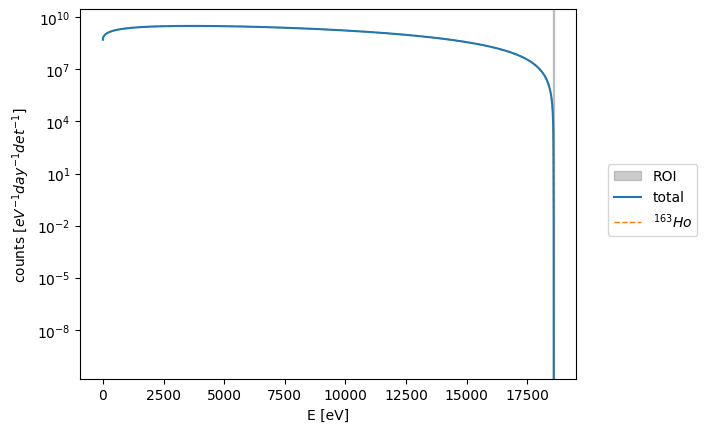

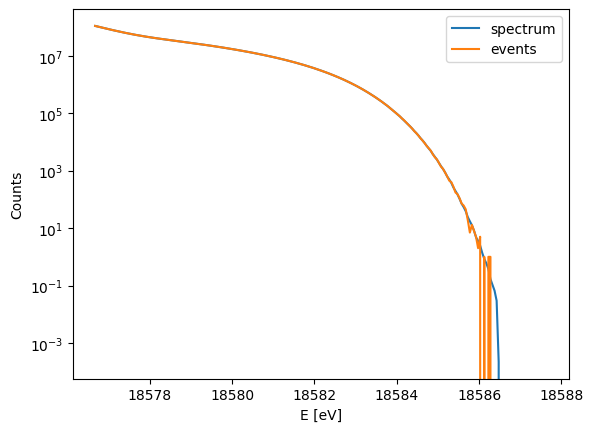

In [104]:
m = 0.2
A = 3.57e8
A_T = A * 1
bkg = 0
FWHM= 0.
n_days = 1* 365
s_Q = 0.07
coeffs = np.loadtxt("parameters.dat")[:,1:]

me = 510998.95
mT = 931.49410242e6*3.01604928;
mhe3 = 931.49410242e6*3.0160293;
mhe = mhe3 - me + 24.6
Q = mT - mhe - me;
Krec = 3.44;
K0 = Q-Krec
n_events  =3.5e9


s = SpectraSampler({'$^{163}Ho$': [ptolemyint, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.05, integrate=True, ROI=[Q-10, Q+1], n_events=n_events)
s.plot_spectrum()
#s.set_measure_time(n_days, n_det=1)

events = s.sample()[0]
s.plot_events(events)

data={'N_bins': len(events),
      'x': s.ROI_bin_centers,
      "N_ev": s.n_events,
      'counts': events,
      'p_Q': Q,
      'p_std_Q': s_Q,
      'p_FWHM': FWHM,
      'p_std_FWHM': 0.01,
      'm_max':10,
      "coeffs": coeffs,
      "prior":1
}

In [96]:
s_sum = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=0.1, dE=0.01, integrate=False, ROI=[Q-10, Q+1])
sp_sum = s_sum.full_spectrum[s_sum.ROI_idx[0]:s_sum.ROI_idx[1]]

In [101]:
N=2
s_sum2 = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=0.1, dE=N*0.01, integrate=False, ROI=[Q-10, Q+1])
sp_sum2 = s_sum2.full_spectrum[s_sum2.ROI_idx[0]:s_sum2.ROI_idx[1]]

/tmp/ipykernel_6057/1609146173.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.plot(s_sum2.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//N, sp_sum)/N-sp_sum2)/sp_sum2)
/tmp/ipykernel_6057/1609146173.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(s_sum2.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//N, sp_sum)/N-sp_sum2)/sp_sum2)


(-0.05, 0.05)

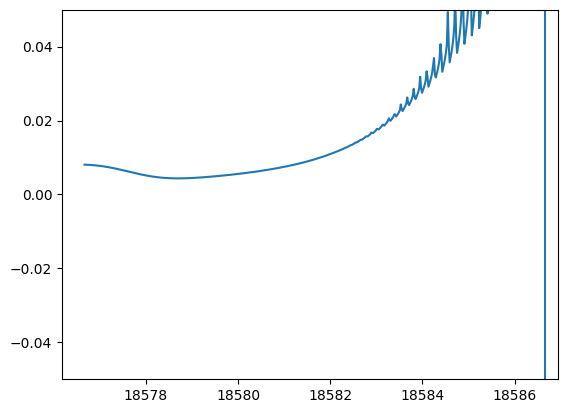

In [102]:
plt.plot(s_sum2.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//N, sp_sum)/N-sp_sum2)/sp_sum2)
plt.axvline(Q)
plt.ylim(-0.05, 0.05)

/tmp/ipykernel_6057/1115375732.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(s.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//2, sp_sum)/2-s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])/s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])


(-0.01, 0.02)

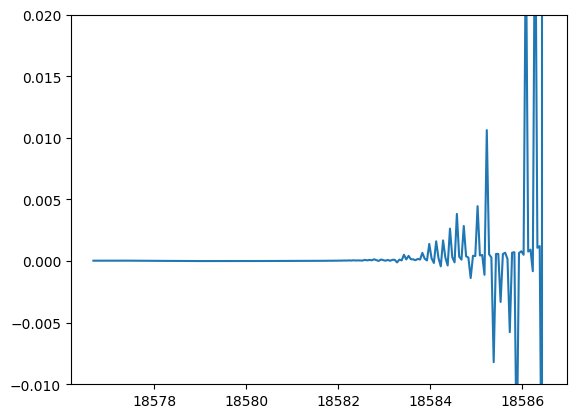

In [52]:
plt.plot(s.ROI_bin_centers, (np.bincount(np.arange(len(sp_sum))//2, sp_sum)/2-s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])/s.full_spectrum[s.ROI_idx[0]:s.ROI_idx[1]])
plt.ylim(-0.01, 0.02)

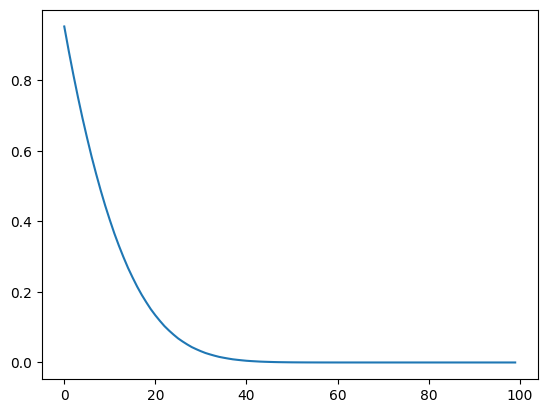

In [35]:
plt.plot(s.full_spectrum[-100:])

In [ ]:
model= get_model("ptolemy_endpoint_allQs.stan")



sampler_kwargs={
    'chains': 4,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "max_treedepth": 12,
    "inits": {"m_red": 0.01, "z": 0, "Qs":np.linspace(0.001, 6, 63)}
}

plot_pars = ['m_nu', 'Q', "Qs[1]", "Qs[2]", "Qs[62]", "Qs[63]"]
p = FitPlotter(col_wrap=4)

#fit = model.sample(data, chains=1, fixed_param=True , iter_sampling=4, iter_warmup=1)

fit = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

In [ ]:
plot_pars = ['m_nu', 'Q', "Qs[1]", "Qs[2]", "Qs[62]", "Qs[63]"]
p.pair_grid(parameters=plot_pars)

In [ ]:
model= get_model("ptolemy_endpoint.stan")

sampler_kwargs={
    'chains': 4,
    'iter_warmup': 500,
    'iter_sampling': 500,
    'save_warmup': True,
    'adapt_delta': 0.9,
    "sig_figs": 10,
    "show_console": False,
    "inits": {"m_red": 0.01, "z": 0}
}

plot_pars = ['m_nu', 'Q']
p = FitPlotter(col_wrap=4)

#fit = model.sample(data, chains=1, fixed_param=True , iter_sampling=4, iter_warmup=1)

fit_noQs = standard_analysis(model, data, p, sampler_kwargs, fit_title='m=0', plot_params = plot_pars)

In [ ]:
p.pair_grid(parameters=['m_nu', 'Q'])

In [ ]:
m = 0.05
A = 3.57e8
A_T = A * 100
bkg = 0
FWHM= 0.1
n_days = 3* 365
Q=18592.01
s_Q = 0.07
coeffs = np.loadtxt("parameters.dat")[:,1:]
model= get_model("ptolemy_endpoint.stan")


def nu_mass_fit(m):

    s = SpectraSampler({'$^{163}Ho$': [ptolemy, [coeffs, m, Q], A_T]}, flat_bkg=bkg, FWHM=FWHM, dE=0.01, integrate=False, ROI=[Q-5, Q+0.5])
    s.set_measure_time(n_days, n_det=1)
    events = s.sample()[0]

    data={'N_bins': len(events),
          'x': s.ROI_bin_centers,
          "N_ev": s.n_events,
          'counts': events,
          'p_Q': Q,
          'p_std_Q': s_Q,
          'p_FWHM': FWHM,
          'p_std_FWHM': 0.01,
          'm_max':10,
          "coeffs": coeffs,
          "prior":0
    }


    inits={}
    inits['m_nu_red'] = np.random.uniform(0,0.05)
    inits['z'] = np.random.normal(0, 0.1)

    sampler_kwargs={
        'chains': 1,
        'iter_warmup': 500,
        'iter_sampling': 1000,
        'save_warmup': False,
        'adapt_delta': 0.9,
        "sig_figs": 10,
        "show_console": False,
        "show_progress": False,
        "inits": inits
    }

    fit = model.sample(data, **sampler_kwargs)
    return fit

n_fits = 64
n_processes = 32
result = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

In [ ]:
a=1
def f():
    return a

In [ ]:
data = {}
efficiency = [0.1, 1, 10, 100]
for e in efficiency:
    A_T = A * e
    data[e] = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    data_array[key] = posteriors
dict_to_json(data_array, "ptolemy/m0.json")

In [ ]:
data = {}
m_nus = [0.05, 0.1, 0.3, 0.5]
for m in m_nus:
    A_T = A * 100
    data[m] = multithreaded_run(nu_mass_fit, [m]*n_fits, n_processes)

m_data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    m_data_array[key] = posteriors
dict_to_json(m_data_array, "ptolemy/msweep100.json")

In [ ]:
from baynes import dict_to_json

data_array = {}
for key, item in data.items():
    posteriors = []
    for fit in item:
        posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
    posteriors = np.array(posteriors)
    data_array[key] = posteriors
dict_to_json(data_array, "ptolemy/m0.json")

### Plot the posteriors for $m_\nu$ and combine their samples in a histogram. The upper limit on the parameter's estimate is given by the confidence interval of this distribution.

In [ ]:
posteriors = []
for fit in data[0.05]:
    posteriors.append(fit.draws_pd()['m_nu'].to_numpy().flatten())
posteriors = np.array(posteriors)

ax = p.new_figure('multi').subplots()
sns.boxplot(posteriors.transpose(), whis=[2.5, 95], showfliers=False, palette='flare', ax=ax)
ax.figure.set_size_inches(25, 5)
ax.set_xticks([])
ax.set_ylabel('m_nu', fontsize=25)


full = posteriors.flatten()
ax = p.new_figure('multi').subplots()
x_max=1

prob = 0.68
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

prob = 0.9
print( str(prob*100) + '% highest density interval: ', hdi(full, prob=prob))
ax.axvspan(hdi(full, prob=prob)[1], x_max, color='gray', alpha=0.2, lw=0)

sns.histplot(posteriors.transpose(), bins=1000, alpha=1, multiple='stack', legend=False, lw=0., palette='flare', ax=ax)
ax.grid(False)
ax.set_xlim(0, x_max)
ax.set_xlabel('m_nu', fontsize=14)
ax.set_ylabel('counts', fontsize=14)
ax.figure.set_size_inches(8, 5)

In [ ]:
his = []
for key, posteriors in m_data_array.items():
    lo, hi = hdi(posteriors.flatten(), prob=0.9)
    his.append(hi)
    plt.scatter([key, key], [lo,hi])
#plt.xscale("log")

In [ ]:
effs = np.log10(np.array(efficiency))
pars = np.polyfit(np.log10(np.array(efficiency)), his, 1)

In [ ]:
plt.plot(effs, np.polyval(pars, effs))

In [ ]:
pars

In [ ]:
help(np.polyval)